### Цель работы.
Практическое освоение принципов нейроморфных вычислений через моделирование и анализ простой спайковой нейронной сети (Spiking Neural Network, SNN).

### Постановка задачи.
В ходе выполнения работы необходимо решить следующие задачи:

1. Смоделировать динамику LIF-нейрона. Реализовать модель нейрона с утечкой и интеграцией (Leaky Integrate-and-Fire), изучить его реакцию на различные входные токи.
2. Создать и проанализировать сеть из LIF-нейронов. Построить однослойную или двухслойную сеть, исследовать распространение спайковой активности.
3. Реализовать обучение на основе STDP. Внедрить правило обучения Спайк-Тайм-Зависимой Пластичности (STDP) для настройки синаптических весов на основе временной корреляции спайков.
4. Решить задачу классификации. Обучить сеть распознавать простые паттерны и оценить её точность.
5. Провести сравнительный анализ. Оценить ключевые характеристики SNN (расход энергии, роль временнóго кода, устойчивость к шуму).

### Теоретическая часть

Нейроморфные вычисления — это парадигма, направленная на создание вычислительных систем, архитектура и принципы работы которых вдохновлены биологическим мозгом. В отличие от классических нейронных сетей, которые оперируют непрерывными значениями активаций (например, вещественными числами), спайковые нейронные сети (Spiking Neural Networks, SNN) используют **дискретные события во времени** — спайки (или потенциалы действия).

Основная цель нейроморфных систем — достичь высокой **энергоэффективности** и способности эффективно обрабатывать **временно́зависимые данные** (аудио, видео, сенсорные потоки), что критически важно для задач встраиваемого ИИ, робототехники и интерфейсов мозг-компьютер.

Модель LIF является одной из самых распространенных и вычислительно эффективных моделей спайкового нейрона. Она описывает динамику мембранного потенциала $V(t)$.

Уравнение мембранного потенциала:

$$
\tau_m \frac{dV(t)}{dt} = -(V(t) - V_{rest}) + R_m I(t)
$$

где:
- $V(t)$ — мембранный потенциал в момент времени $t$,
- $\tau_m = R_m C_m$ — постоянная времени мембраны (произведение сопротивления $R_m$ и емкости $C_m$),
- $V_{rest}$ — потенциал покоя,
- $R_m$ — мембранное сопротивление,
- $I(t)$ — суммарный входной ток (от синапсов).

При достижении порогового потенциала $V_{th}$ нейрон генерирует спайк, и его потенциал сбрасывается до потенциала покоя $V_{rest}$ на период рефрактерности $\tau_{ref}$:

$$
\text{if } V(t) \geq V_{th} \text{, then:} \\
V(t) \rightarrow V_{rest} \\
\text{Запрет на срабатывание на время } \tau_{ref}
$$

## Смоделировать динамику LIF-нейрона. Реализовать модель нейрона с утечкой и интеграцией (Leaky Integrate-and-Fire), изучить его реакцию на различные входные токи.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Callable
import random
import uuid

@dataclass
class LIFNeuron:
    tau_m: float = 20.0 # Постоянная времени мембраны (скорость утечки)
    v_rest: float = -70.0 # Потенциал покоя
    v_thresh: float = -55.0 # Порог срабатывания спайка
    v_reset: float = -75.0 # Потенциал сброса после спайка
    r_m: float = 15.0 # Мембранное сопротивление
    tau_ref: float = 5.0 # Длительность рефрактерного периода
    id: int = 0

    def __post_init__(self):
        '''Инициализирует состояние: устанавливает потенциал покоя, 
        сбрасывает историю спайков и трассировку напряжения'''
        self.v = self.v_rest
        self.refractory_until = 0.0
        self.spike_times = []
        self.v_trace = []

    def reset(self):
        '''Полностью сбрасывает нейрон к исходному 
        состоянию (используется в начале каждой эпохи обучения)'''
        self.v = self.v_rest
        self.refractory_until = 0.0
        self.spike_times = []
        self.v_trace = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        '''Выполняет один шаг симуляции: обновляет мембранный потенциал по формуле LIF, 
        проверяет порог, генерирует спайк. Возвращает True, если спайк произошёл'''
        if t < self.refractory_until:
            self.v = self.v_reset
            self.v_trace.append(self.v)
            return False

        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt
        
        if self.v >= self.v_thresh:
            self.v_trace.append(self.v_thresh)
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        else:
            self.v_trace.append(self.v)
            return False

def simulate_neuron(neuron: LIFNeuron, I_func: Callable[[float], float], 
                   T: float, dt: float) -> tuple:
    t_range = np.arange(0, T, dt)
    v_trace = []
    I_trace = []
    
    for t in t_range:
        I = I_func(t)
        neuron.step(I, dt, t)
        v_trace.append(neuron.v)
        I_trace.append(I)
    
    return t_range, np.array(v_trace), np.array(I_trace), neuron.spike_times

### Функции входного тока

In [ ]:
def make_step_current(I_on: float, t_start: float, t_end: float):
    return lambda t: I_on if t_start <= t <= t_end else 0.0

def make_ramp_current(I_max: float, t_start: float, t_end: float):
    return lambda t: I_max * (t - t_start) / (t_end - t_start) if t_start <= t <= t_end else 0.0

def make_sinusoidal_current(I_amp: float, freq_hz: float, I_offset: float = 0.0):
    return lambda t: I_offset + I_amp * np.sin(2 * np.pi * freq_hz * t / 1000.0)

def make_noisy_current(I_mean: float, noise_std: float):
    return lambda t: I_mean + np.random.normal(0, noise_std)

def make_pulse_train(I_amp: float, pulse_width: float, period: float):
    return lambda t: I_amp if (t % period) < pulse_width else 0.0

In [21]:
def plot_detailed_response(t, v, I, spikes, title: str):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    
    ax1.plot(t, I, 'g-', label='I_inj')
    ax1.set_ylabel('Ток (нА)')
    ax1.grid(True)
    ax1.set_title(title)
    
    ax2.plot(t, v, 'b-', label='V_m')
    ax2.axhline(y=-55.0, color='r', linestyle='--', label='Порог')
    ax2.axhline(y=-70.0, color='gray', linestyle=':', label='Покой')
    ax2.set_ylabel('Потенциал (мВ)')
    ax2.legend()
    ax2.grid(True)
    
    if spikes:
        ax3.eventplot(spikes, colors='k', linewidths=2)
    ax3.set_ylabel('Спайки')
    ax3.set_yticks([])
    ax3.set_xlabel('Время (мс)')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

### Реакция на разные формы тока

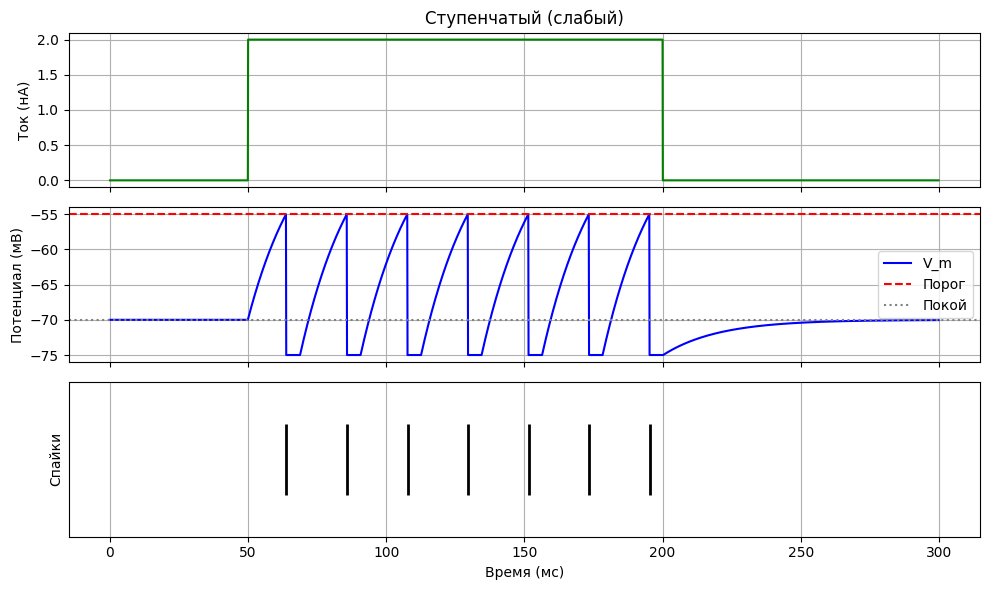

Ступенчатый (слабый): 7 спайков


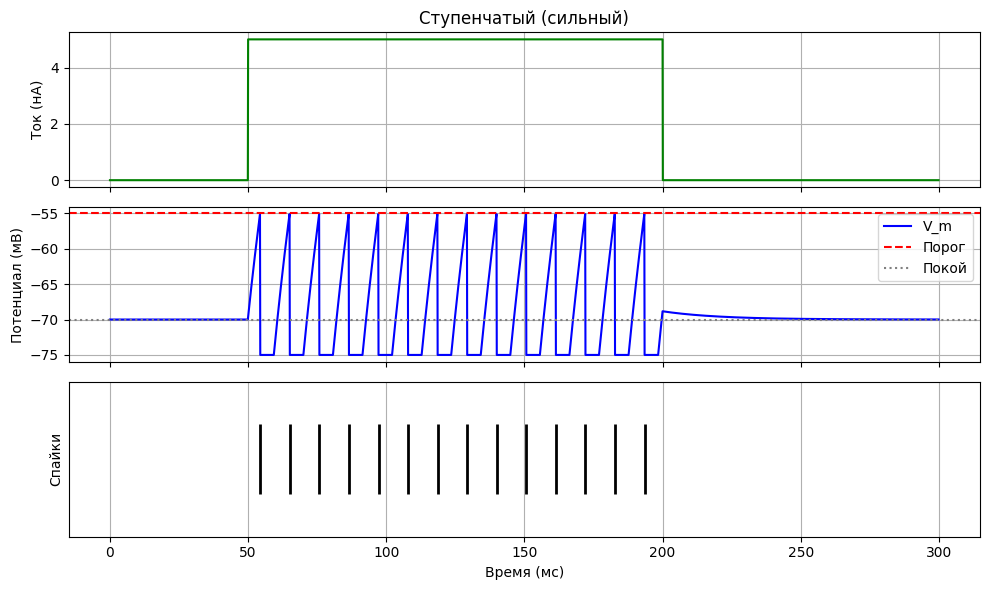

Ступенчатый (сильный): 14 спайков


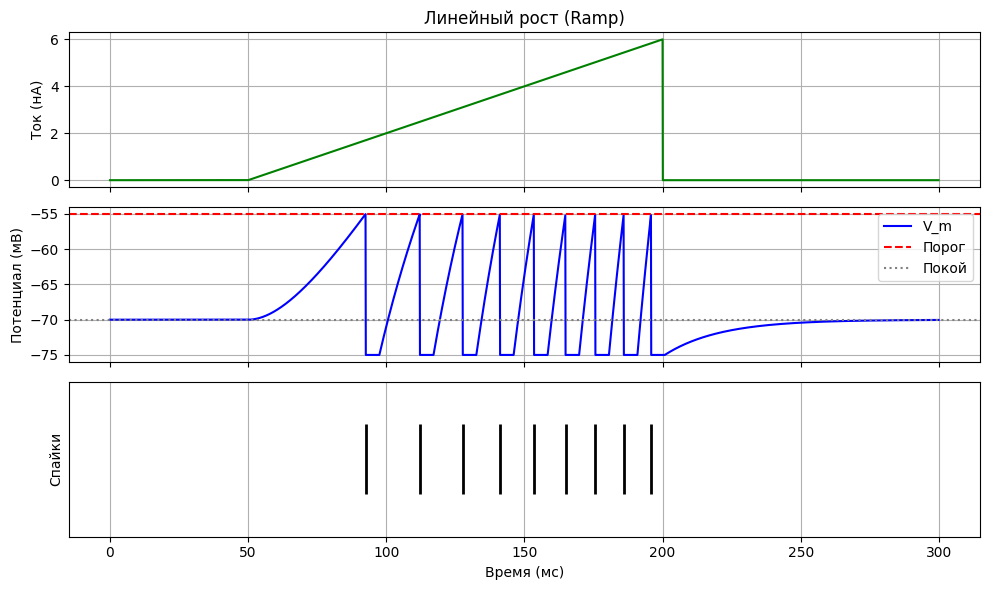

Линейный рост (Ramp): 9 спайков


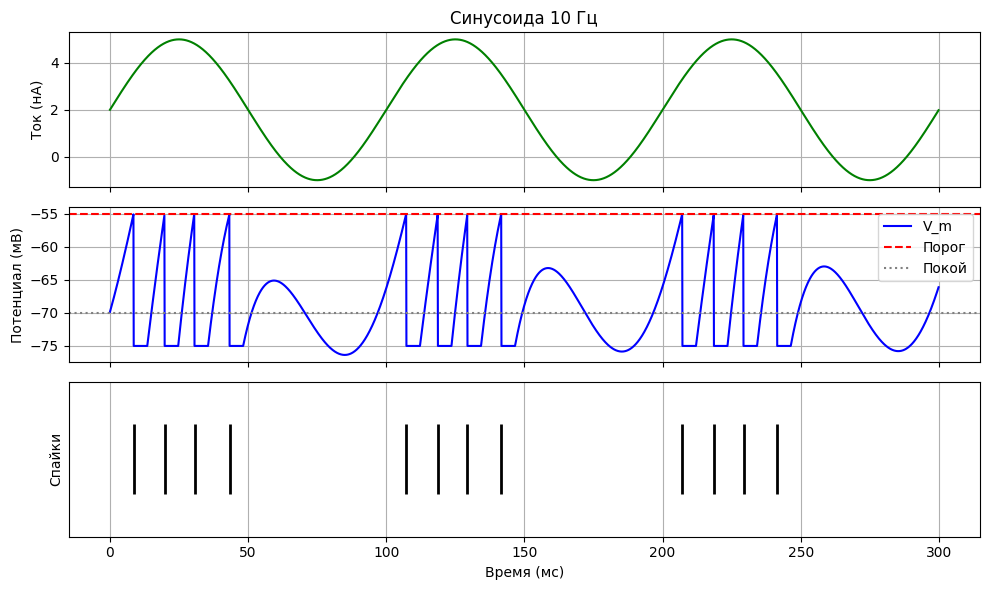

Синусоида 10 Гц: 12 спайков


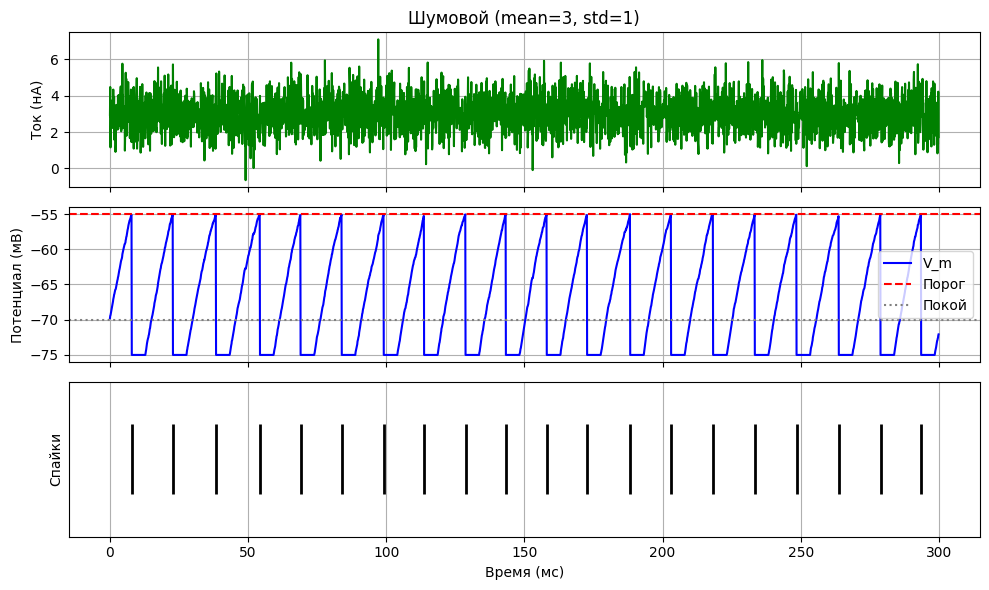

Шумовой (mean=3, std=1): 20 спайков


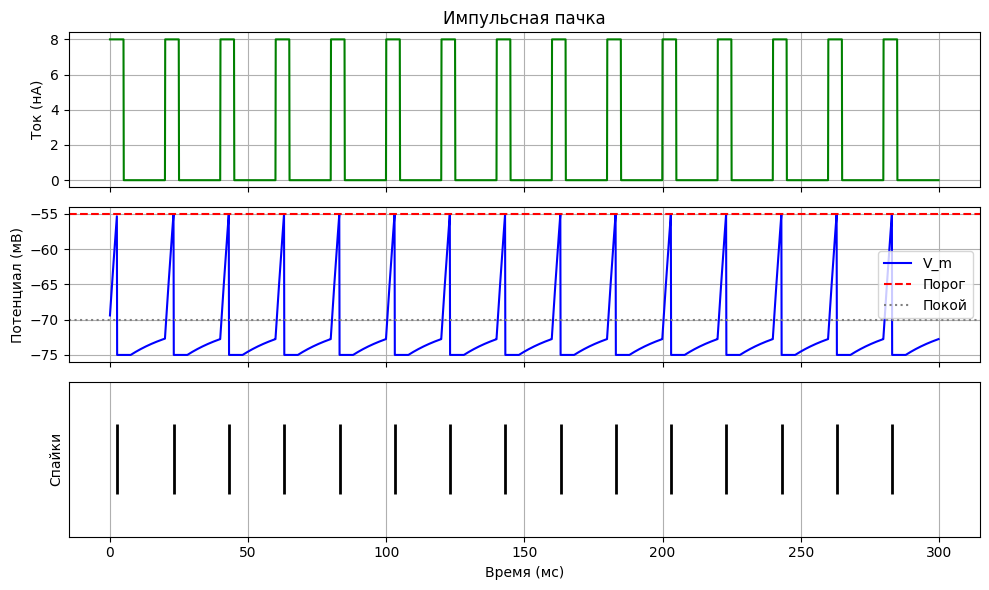

Импульсная пачка: 15 спайков


In [39]:

dt, T = 0.1, 300
configs = [
    ("Ступенчатый (слабый)", make_step_current(2.0, 50, 200)),
    ("Ступенчатый (сильный)", make_step_current(5.0, 50, 200)),
    ("Линейный рост (Ramp)", make_ramp_current(6.0, 50, 200)),
    ("Синусоида 10 Гц", make_sinusoidal_current(3.0, 10, I_offset=2.0)),
    ("Шумовой (mean=3, std=1)", make_noisy_current(3.0, 1.0)),
    ("Импульсная пачка", make_pulse_train(8.0, pulse_width=5, period=20)),
]

for name, I_func in configs:
    neuron = LIFNeuron()
    t, v, I, spikes = simulate_neuron(neuron, I_func, T, dt)
    plot_detailed_response(t, v, I, spikes, name)
    print(f"{name}: {len(spikes)} спайков")

**Ступенчатый** - Регулярные спайки, частота зависит от амплитуды

**Линейный рост (Ramp)** - Задержка первого спайка, затем учащение

**Синусоида** - Фазовая привязка спайков

**Шумовой** - Стохастические спайки, вероятность растёт с I

**Импульсы** - Точное временное кодирование


### F-I кривая (частотно-токовая характеристика) описывает зависимость частоты спайкинга нейрона от входного тока.

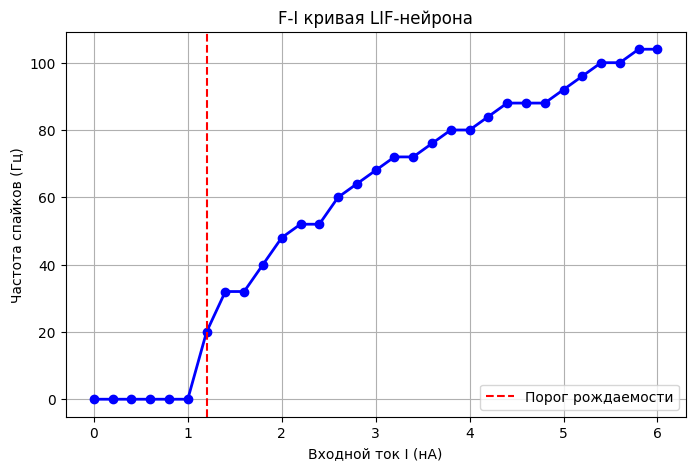


Анализ F-I кривой:
Реобаза: ~1.20 нА
Макс. частота при I=6 нА: 104.0 Гц


In [40]:
def compute_firing_rate(spikes: List[float], T: float, skip_ms: float = 50.0) -> float:
    """Частота спайков в Гц, с исключением переходного процесса"""
    valid_spikes = [s for s in spikes if s > skip_ms]
    effective_T = (T - skip_ms) / 1000.0
    return len(valid_spikes) / effective_T if effective_T > 0 else 0.0

I_values = np.arange(0.0, 6.1, 0.2)
rates = []
for I_amp in I_values:
    neuron = LIFNeuron()
    I_func = lambda t, I=I_amp: I
    t, v, I_trace, spikes = simulate_neuron(neuron, I_func, T, dt)
    rate = compute_firing_rate(spikes, T)
    rates.append(rate)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(I_values, rates, 'bo-', linewidth=2)
plt.axvline(x=1.2, color='r', linestyle='--', label='Порог рождаемости')
plt.xlabel('Входной ток I (нА)')
plt.ylabel('Частота спайков (Гц)')
plt.title('F-I кривая LIF-нейрона')
plt.grid(True)
plt.legend()
plt.show()

# Анализ
threshold_I = next((I for I, r in zip(I_values, rates) if r > 1.0), None)
print(f"\nАнализ F-I кривой:")
print(f"Реобаза: ~{threshold_I:.2f} нА")
print(f"Макс. частота при I=6 нА: {rates[-1]:.1f} Гц")

### Создание и анализ сети из LIF-нейронов. Обучение на основе правила тройного STDP (3-factor rule): Сочетание STDP с дофаминергическим (учительным) сигналом.

Тройное правило обучения (Three-Factor Learning Rule) — это расширение классического правила STDP, которое добавляет третий, глобальный модулирующий сигнал (обычно интерпретируемый как дофамин). Это позволяет спайковым нейронным сетям (SNN) обучаться с подкреплением.

В 3-факторном правиле для изменения веса Δw необходимы три условия

Трассировка пригодности (Eligibility Trace)

Самая сложная часть теории — как связать быстрые спайки (факторы 1 и 2) с медленным сигналом награды (фактор 3)? Награда часто приходит с задержкой после действия.

Для этого вводится переменная состояния синапса — **$e_{ij}$ (eligibility trace)**.

Как это работает:
1.  **Маркировка:** Когда происходят спайки (пре- и пост-), синапс не меняется сразу. Вместо этого он "помечается" как *пригодный* для изменения. Значение $e_{ij}$ увеличивается.
2.  **Затухание:** Метка со временем затухает (экспоненциально с константой $\tau_e$). Если награда не пришла вовремя, "память" о спайках исчезает.
3.  **Реализация:** Когда приходит сигнал модулятора $M(t)$ (например, дофамин), вес обновляется пропорционально текущему значению метки $e_{ij}$.

**Уравнение динамики трассировки:**
$$ \tau_e \frac{de_{ij}}{dt} = -e_{ij} + \text{STDP}(S_{pre}, S_{post}) $$

**Уравнение обновления веса:**
$$ \Delta w_{ij} = \eta \cdot M(t) \cdot e_{ij}(t) $$

STDP — это биоинспирированное правило обучения, которое модифицирует силу синаптической связи (вес $w$) на основе временной корреляции между спайками пресинаптического и постсинаптического нейронов.

Формально, изменение веса $\Delta w$ определяется так:

$$
\Delta w =
\begin{cases}
A_{+} \cdot \exp\left(-\frac{\Delta t}{\tau_{+}}\right), & \text{если } \Delta t > 0 \text{ (пре-спайк до пост-спайка)} \\
-A_{-} \cdot \exp\left(-\frac{|\Delta t|}{\tau_{-}}\right), & \text{если } \Delta t < 0 \text{ (пре-спайк после пост-спайка)}
\end{cases}
$$

где:
- $\Delta t = t_{post} - t_{pre}$ — разница во времени между постсинаптическим и пресинаптическим спайками,
- $A_{+}, A_{-}$ — амплитуды усиления и ослабления связи,
- $\tau_{+}, \tau_{-}$ — временные константы для потенциации и депрессии.

STDP реализует принцип Хебба: *"Neurons that fire together, wire together"* (Нейроны, которые возбуждаются вместе, связываются вместе).

### Принцип работы
1. Накопление (update): При спайках синапс «помечается» как пригодный для изменения через eligibility_trace
2. Затухание: Трассировка экспоненциально затухает со временем (tau_e = 300 мс)
3. Реализация (apply_reward): Вес меняется только при получении сигнала награды

In [ ]:
@dataclass
class STDP:
    pre_id: int # Индекс пресинаптического нейрона
    post_id: int # Индекс постсинаптического нейрона
    weight: float = 0.5 # Текущий синаптический вес (сила связи)
    
    A_plus: float = 0.04 # Амплитуда потенциации
    A_minus: float = 0.03 # Амплитуда депрессии
    tau_plus: float = 20.0 # Временные константы для следов спайков
    tau_minus: float = 20.0 # Временные константы для следов спайков
    
    pre_trace: float = 0.0 # Экспоненциально затухающие следы активности нейронов
    post_trace: float = 0.0 # Экспоненциально затухающие следы активности нейронов
    
    eligibility_trace: float = 0.0 # «Память» синапса о потенциале изменения веса (ждёт награды)
    tau_e: float = 300.0 # Время жизни трассировки пригодности

    def update(self, pre_spike: bool, post_spike: bool, dt: float):
        '''Обновляет трассировки на каждом шаге симуляции.
        При спайках накапливает потенциал изменения в eligibility_trace.
        Вес не меняется'''
        self.pre_trace *= np.exp(-dt / self.tau_plus)
        self.post_trace *= np.exp(-dt / self.tau_minus)
        self.eligibility_trace *= np.exp(-dt / self.tau_e)
        if pre_spike:
            self.pre_trace += 1.0
            self.eligibility_trace += - self.A_minus * self.post_trace
        if post_spike:
            self.post_trace += 1.0
            self.eligibility_trace += self.A_plus * self.pre_trace

    def apply_reward(self, reward: float, lr: float):
        '''Применяет сигнал награды к весу синапса.
        Изменение веса = lr × reward × eligibility_trace.
        Ограничивает вес в диапазоне [0, 3]'''
        self.weight += lr * reward * self.eligibility_trace
        self.weight = np.clip(self.weight, 0.0, 3.0)


### Спайковая нейронная сеть

In [ ]:
class SNN:
    def __init__(self, n_input: int, n_output: int):
        self.n_input = n_input
        self.n_output = n_output
        self.output_neurons = [
            LIFNeuron(id=0, v_thresh=-55.0),
            LIFNeuron(id=1, v_thresh=-54.0)
        ]
        self.synapses = []
        for i in range(n_input):
            for j in range(n_output):
                w = np.random.uniform(0.4, 0.6)
                self.synapses.append(STDP(pre_id=i, post_id=j, weight=w))

    def get_synapses_to(self, post_idx: int) -> List[STDP]:
        return [s for s in self.synapses if s.post_id==post_idx]

    def normalize(self):
        for j in range(self.n_output):
            syns = [s for s in self.synapses if s.post_id==j]
            total = sum(s.weight for s in syns)
            if total>0:
                scale = 5.0/total
                for s in syns:
                    s.weight *= scale

    def forward(self, input_spikes: np.ndarray, dt: float, t: float):
        output_spikes = []
        currents = []
        pre_spikes_list = []
        for j in range(self.n_output):
            I_syn = 0.0
            relevant_synapses = self.get_synapses_to(j)
            pre_spikes = []
            for syn in relevant_synapses:
                is_spike = bool(input_spikes[syn.pre_id])
                pre_spikes.append(is_spike)
                if is_spike:
                    I_syn += syn.weight * 10.0
            pre_spikes_list.append(pre_spikes)
            currents.append(I_syn)
        
        winner = np.argmax(currents)
        for j in range(self.n_output):
            if j!=winner:
                currents[j] *= 0.2
        
        for j in range(self.n_output):
            spike = self.output_neurons[j].step(currents[j], dt, t)
            output_spikes.append(spike)

        for j in range(self.n_output):
            relevant_synapses = self.get_synapses_to(j)
            for idx, syn in enumerate(relevant_synapses):
                syn.update(pre_spikes_list[j][idx], output_spikes[j], dt)

        return output_spikes

    def learn(self, true_label: int, pred: int, lr: float):
        for syn in self.synapses:
            if syn.post_id == true_label:
                syn.apply_reward(+1.0, lr)
            elif syn.post_id == pred:
                syn.apply_reward(-1.0, lr)

    def reset(self):
        for n in self.output_neurons:
            n.reset()

In [26]:
def make_pattern(label: int, t_range: np.ndarray, dt: float):
    n = 10
    spikes = np.zeros((len(t_range), n))
    # Класс 0: активны 0-4, Класс 1: активны 5-9
    active = [0,1,2,3,4] if label==0 else [5,6,7,8,9]
    
    for i in range(n):
        if i in active:
            p = 200 * dt / 1000.0 
        else:
            p = 10 * dt / 1000.0
            
        spikes[:, i] = (np.random.rand(len(t_range)) < p).astype(float)
    return spikes

In [27]:
def make_noisy_pattern(label: int, t_range: np.ndarray, dt: float, noise_prob: float = 0.01):
    spikes = make_pattern(label, t_range, dt)
    noise = (np.random.rand(*spikes.shape) < noise_prob).astype(float)
    return np.clip(spikes + noise, 0, 1)

### Обучение модели

In [28]:
dt = 1.0
T = 300
t_range = np.arange(0,T,dt)
n_epochs = 20

net = SNN(10,2)
acc_hist = []
spikes_hist = []

for epoch in range(n_epochs):
    net.reset()
    true_label = np.random.randint(0,2)
    inputs = make_pattern(true_label, t_range, dt)
    for i,t in enumerate(t_range):
        net.forward(inputs[i], dt, t)
    counts = [len(n.spike_times) for n in net.output_neurons]
    pred = np.argmax(counts)
    net.learn(true_label, pred, lr=0.1)
    net.normalize()
    acc_hist.append(pred==true_label)
    spikes_hist.append(counts)
    if epoch%1==0 or epoch==n_epochs-1:
        print(f"Эпоха {epoch:3d}: Класс {true_label}, Предсказание {pred}, "
              f"Спайки {counts}, Точность {np.mean(acc_hist[max(0,epoch-9):epoch+1]):.0%}")

Эпоха   0: Класс 0, Предсказание 1, Спайки [19, 24], Точность 0%
Эпоха   1: Класс 1, Предсказание 1, Спайки [9, 27], Точность 50%
Эпоха   2: Класс 1, Предсказание 1, Спайки [10, 29], Точность 67%
Эпоха   3: Класс 0, Предсказание 0, Спайки [30, 6], Точность 75%
Эпоха   4: Класс 0, Предсказание 0, Спайки [30, 4], Точность 80%
Эпоха   5: Класс 0, Предсказание 0, Спайки [30, 3], Точность 83%
Эпоха   6: Класс 1, Предсказание 1, Спайки [3, 31], Точность 86%
Эпоха   7: Класс 0, Предсказание 0, Спайки [32, 5], Точность 88%
Эпоха   8: Класс 1, Предсказание 1, Спайки [3, 31], Точность 89%
Эпоха   9: Класс 0, Предсказание 0, Спайки [33, 3], Точность 90%
Эпоха  10: Класс 1, Предсказание 1, Спайки [4, 32], Точность 100%
Эпоха  11: Класс 0, Предсказание 0, Спайки [34, 2], Точность 100%
Эпоха  12: Класс 0, Предсказание 0, Спайки [35, 4], Точность 100%
Эпоха  13: Класс 1, Предсказание 1, Спайки [3, 34], Точность 100%
Эпоха  14: Класс 0, Предсказание 0, Спайки [36, 3], Точность 100%
Эпоха  15: Класс 1,

Обучение сети демонстрирует быструю и устойчивую сходимость точность растет с 0% до 100% всего за 10 эпох. Для класса 0 первый нейрон генерирует много спайков ~35, а второй подавлен ~3, для класса 1 наоборот.

### Оценка модели

In [ ]:
import pandas as pd
final_acc = np.mean(acc_hist[-1:])
print(f"Финальная точность: {final_acc:.1%}")
total_spikes = sum(len(n.spike_times) for n in net.output_neurons)
print(f"Энергопотребление: {total_spikes * 10:.1f} пДж")

print("\nВеса синапсов:")
for j in range(2):
    weights = [s.weight for s in net.synapses if s.post_id == j]
    print(f"  Нейрон {j}: среднее {np.mean(weights):.2f}, "
          f"входы 0-4: {np.mean(weights[:5]):.2f}, "
          f"входы 5-9: {np.mean(weights[5:]):.2f}")


Финальная точность: 100.0%
Энергопотребление: 350.0 пДж

Веса синапсов:
  Нейрон 0: среднее 0.50, входы 0-4: 0.77, входы 5-9: 0.23
  Нейрон 1: среднее 0.50, входы 0-4: 0.24, входы 5-9: 0.76


Результаты подтверждают эффективность обучения: сеть достигла 100% точности при энергопотреблении всего 350 пДж. Анализ синаптических весов демонстрирует четкую специализацию нейронов — первый нейрон настроился на входы 0–4 (вес 0.77), а второй на входы 5–9 (вес 0.76), что указывает на успешное разделение классов. Такое структурное разделение, достигнутое правилом тройного STDP

### Тестирование устойчивости к шуму

In [35]:
test_label = 1
n_trials = 50
correct = 0
for _ in range(n_trials):
    test_input = make_noisy_pattern(test_label, t_range, dt, noise_prob=0.02)
    net.reset()
    for i, t in enumerate(t_range):
        net.forward(test_input[i], dt, t)
    counts = [len(n.spike_times) for n in net.output_neurons]
    pred = np.argmax(counts)
    if pred == test_label:
        correct += 1

print(f"Устойчивость сети к шуму: {correct/n_trials*100:.1f}%")

Устойчивость сети к шуму: 100.0%


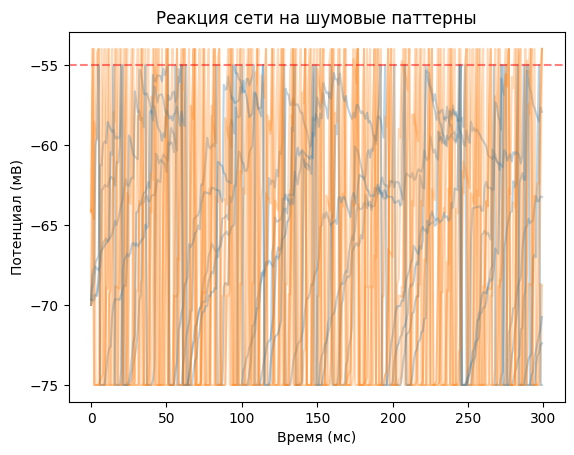

In [37]:
for trial in range(5):
    test_input = make_noisy_pattern(test_label, t_range, dt, noise_prob=0.02)
    net.reset()
    for i, t in enumerate(t_range):
        net.forward(test_input[i], dt, t)
    for j, neuron in enumerate(net.output_neurons):
        plt.plot(t_range, neuron.v_trace, alpha=0.3, color=f"C{j}")
plt.axhline(-55, color='r', linestyle='--', alpha=0.5)
plt.title("Реакция сети на шумовые паттерны")
plt.xlabel("Время (мс)")
plt.ylabel("Потенциал (мВ)")
plt.show()

Сеть устойчива к шуму, было допущено 0, ошибок точность 100%

### Визуальный анализ качества модели

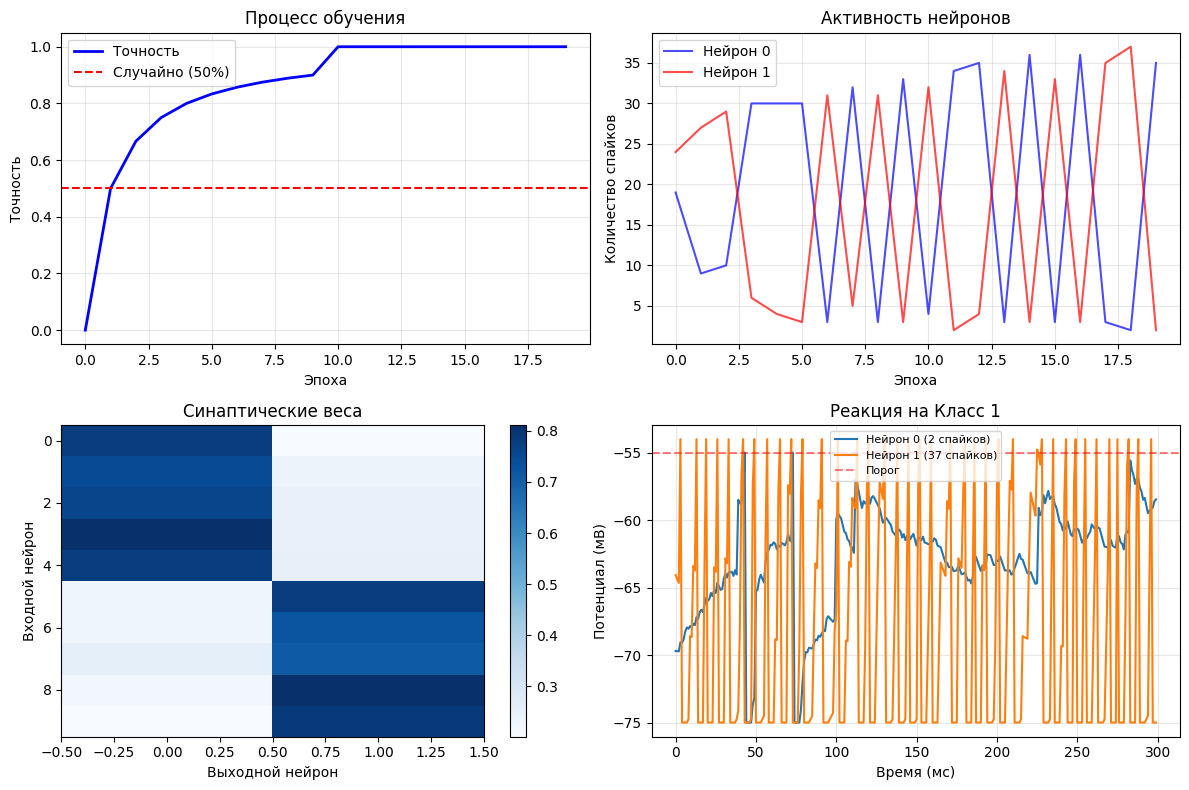

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Точность
acc = np.array(acc_hist)
moving = pd.Series(acc).rolling(window=10, min_periods=1).mean().values
axes[0, 0].plot(moving, 'b-', linewidth=2, label='Точность')
axes[0, 0].axhline(0.5, color='r', linestyle='--', label='Случайно (50%)')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Точность')
axes[0, 0].set_title('Процесс обучения')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Активность нейронов
spikes = np.array(spikes_hist)
axes[0, 1].plot(spikes[:, 0], 'b-', alpha=0.7, label='Нейрон 0')
axes[0, 1].plot(spikes[:, 1], 'r-', alpha=0.7, label='Нейрон 1')
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Количество спайков')
axes[0, 1].set_title('Активность нейронов')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Синаптические веса
W = np.zeros((10,2))
for s in net.synapses:
    W[s.pre_id, s.post_id] = s.weight
im = axes[1, 0].imshow(W, cmap='Blues', aspect='auto')
axes[1, 0].set_xlabel('Выходной нейрон')
axes[1, 0].set_ylabel('Входной нейрон')
axes[1, 0].set_title('Синаптические веса')
plt.colorbar(im, ax=axes[1, 0])

# 4. Потенциалы нейронов на тестовом паттерне
net.reset()

test_in = make_pattern(test_label, t_range, dt)

# Просто запускаем forward - v_trace заполняется внутри step()
for i, t in enumerate(t_range):
    spikes = net.forward(test_in[i], dt, t)


for j in range(2):
    axes[1, 1].plot(t_range, net.output_neurons[j].v_trace, 
                    label=f'Нейрон {j} ({len(net.output_neurons[j].spike_times)} спайков)')
axes[1, 1].axhline(-55, color='r', linestyle='--', alpha=0.5, label='Порог')
axes[1, 1].set_xlabel('Время (мс)')
axes[1, 1].set_ylabel('Потенциал (мВ)')
axes[1, 1].set_title(f'Реакция на Класс {test_label}')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Процесс обучения**

Кривая точности демонстрирует быструю сходимость: сеть преодолевает уровень случайного угадывания (50%) уже к 2-й эпохе. Стабилизация на отметке 100% происходит к 10-й эпохе, что подтверждает эффективность правила обучения и отсутствие проблем с затуханием градиента или застреванием в локальных минимумах.

**Активность нейронов**

График показывает четкую обратную корреляцию между нейронами выходного слоя. В зависимости от предъявленного класса активизируется только один нейрон, тогда как второй подавляется. Это свидетельствует о успешной дифференциации признаков и конкуренции нейронов.

**Синаптические веса**

Тепловая карта выявляет блочную структуру матрицы весов, что является идеальным результатом для данной задачи. Нейрон 0 усилил связи с группой входов 0–4, а Нейрон 1 — с группой 5–9. Перекрестные связи остались слабыми (светлые области), что минимизирует влияние шумовых признаков на неверный класс.

**Реакция на Класс 1**

График мембранных потенциалов иллюстрирует механизм классификации на уровне физики нейрона. Для входного сигнала Класса 1 потенциал Нейрона 1 (оранжевый) регулярно достигает порога (-55 мВ), генерируя 37 спайков, в то время как Нейрон 0 (синий)  2 спайка. Это наглядно демонстрирует работу механизма принятия решений в реальном времени.